In [ ]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    brier_score_loss,
    RocCurveDisplay)
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
import json
from pathlib import Path
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import joblib
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from os import listdir
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
np.random.seed(42)
RANDOM_STATE= 42
data_folder= "data/"
image_folder = "artifacts/figures/"
artifacts_folder="artifacts/"
datasets_files = [data_folder+i for i in listdir("data/")]
def plot_k_metrics(metrics, title_suffix=""):
    k = metrics["k"]
    inertia = metrics["inertia"]
    sil = metrics["silhouette"]

    plt.figure(figsize=(7, 4))
    plt.plot(k, inertia, marker="o")
    plt.title(f"Inertia vs K{title_suffix}")
    plt.xlabel("K")
    plt.ylabel("inertia_ (ниже лучше)")
    plt.grid(True, alpha=0.25)
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(k, sil, marker="o")
    plt.title(f"Silhouette vs K{title_suffix}")
    plt.xlabel("K")
    plt.ylabel("silhouette (выше лучше)")
    plt.grid(True, alpha=0.25)
    plt.show()
def plot_clusters(X,labels,title='',fig=None,ax=None,save_file=None):
    X= PCA(2,random_state=RANDOM_STATE).fit_transform(X)
    if ax is None or fig is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    labels = np.asarray(labels)
    unique = sorted(set(labels))
    for lab in unique:
        mask = labels == lab
        if lab == -1:
            ax.scatter(X[mask, 0], X[mask, 1], s=20, marker="x", label="noise (-1)")
        else:
            ax.scatter(X[mask, 0], X[mask, 1], s=20, label=f"cluster {lab}")
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.grid(True, alpha=0.25)
    ax.legend(loc="best")
    if save_file !=None:
        fig.savefig(save_file)
    fig.show()
    #print(X)
def safe_internal_metrics(X, labels):
    
    labels = np.asarray(labels)
    mask = labels != -1
    X2 = X[mask]
    y2 = labels[mask]

    result = {}

    
    if len(set(y2)) < 2:
        result["silhouette"] = None
        result["calinski_harabasz"] = None
        result["davies_bouldin"] = None
        return result

    result["silhouette"] = float(silhouette_score(X2, y2))
    result["calinski_harabasz"] = float(calinski_harabasz_score(X2, y2))
    result["davies_bouldin"] = float(davies_bouldin_score(X2, y2))
    return result
def save_with_clusters(label,dataset,save_path=''):
    dataset=dataset.copy()
    dataset.insert(1,"cluster_label", label)
    dataset.to_csv(save_path,index=False)
def summarize_labels(labels):
    """Короткая статистика по разметке: число кластеров, доля шума."""
    labels = np.asarray(labels)
    n_noise = np.count_nonzero(labels == -1) / len(labels)
    n_points = len(labels)
    clusters = sorted([c for c in set(labels) if c != -1])
    return {
        "n_points": n_points,
        "n_clusters": len(clusters),
        "n_noise": float(n_noise),
        "noise_share": float(n_noise / n_points)
    }
def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)




In [28]:
datasets = []
for i in datasets_files:
    
    datasets.append( pd.read_csv(i))
    #datasets[-1].fillna(0,inplace=True)
    datasets[-1].dropna(inplace=True) #удаляю пропуски
    print("Dataset name:",i)
    print(datasets[-1].head())
    print("Describe:")
    print(datasets[-1].describe())
    print("Info:")
    datasets[-1].info()
    
    print("Features:",*list(datasets[-1].keys())[1:])
    #print(datasets[-1].value_counts(v,normalize=True))
    print("Shape:",datasets[-1].shape)
    print()





Dataset name: data/S07-hw-dataset-01.csv
   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  
Describe:
         sample_id           f01           f02           f03           f04  \
count  12000.00000  12000.000000  12000.000000  12000.000000  12000.000000   
mean    5999.50000     -2.424716     19.107804     -0.222063     -8.284501   
std     3464.24595     11.014315     60.790338      0.500630     59.2698

In [29]:
datasets[-1].shape

(5490, 33)

In [30]:
x_scaled= []

for i in datasets:
    metrics_to_see=list(i.keys())
    metrics_to_see.remove("sample_id")
    try:
        metrics_to_see.remove("cat_a")
        metrics_to_see.remove("cat_b")
    except:
        pass
    preprocessing=sk.pipeline.Pipeline([#("Encoder",sk.preprocessing.OneHotEncoder(handle_unknown="ignore")),
                                        ("Scaler",sk.preprocessing.StandardScaler())])

    x_scaled.append(preprocessing.fit_transform(i[metrics_to_see].values))
    del preprocessing
    
    
print(x_scaled[-1])



[[-0.98988026 -0.03688465  0.78258556 ... -2.42458719 -0.96522239
   0.49923022]
 [-0.89278077 -1.21201551 -0.67432923 ... -0.87319366 -0.72464958
  -1.55069653]
 [-1.28184806 -0.3546128   1.59195372 ...  1.04845168  0.49293119
  -0.42285612]
 ...
 [ 0.93698323 -0.83192254 -0.22107996 ...  1.13388159  0.8635876
  -0.9237569 ]
 [ 1.06252932 -0.02796905 -0.43395485 ... -0.57073612  1.46940528
   0.1131712 ]
 [ 0.70768112  2.05074079 -1.31718753 ... -0.70125532  0.66852476
  -0.33579373]]


[2 1 1 ... 0 1 3]
[[-4.90896856e-01  8.37216479e-01  3.93704305e-01 -8.15427919e-02
  -4.56588965e-02 -6.07882619e-01 -7.42378865e-03  1.51420451e-03]
 [ 1.81276029e+00  6.74286453e-01 -1.94624398e+00 -1.59261113e+00
   1.46106194e+00  1.91245075e+00 -1.01222963e-02 -2.68468764e-02]
 [ 2.14209748e-01 -1.50191801e+00  3.58571075e-01  1.24465174e+00
  -1.45949545e+00 -6.68321027e-01  7.99149434e-03 -1.76989786e-02]
 [-1.04517633e+00 -8.46801405e-01  8.00264296e-01  5.11044966e-01
   8.97513032e-02 -2.83644879e-02  1.69783793e-02  4.15174460e-02]]


C:\Users\study\AppData\Local\Temp\ipykernel_19896\4099117291.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[1 2 0 ... 0 3 3]
[[-0.53280438  0.81934288 -0.80278201]
 [ 0.74156168 -0.61670503  0.78771281]
 [-0.85942043  0.54038777  0.74529405]
 [ 0.61459163 -0.70273409 -0.81367279]]


C:\Users\study\AppData\Local\Temp\ipykernel_19896\4099117291.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[3 1 1 ... 1 1 1]
[[ 1.26559067  1.03706711  0.70931683 -0.03644397]
 [ 0.31354476 -0.97619232  0.7503278   0.00609566]
 [-1.55563578 -0.85345151 -1.02780325  0.01379238]
 [-0.49150864  0.67979814 -0.79918719  0.0132088 ]]


C:\Users\study\AppData\Local\Temp\ipykernel_19896\4099117291.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[2 3 2 ... 1 1 0]
[[ 5.97492811e-01  1.98598366e+00 -1.31807499e+00 -7.28802885e-01
   8.86014508e-01  5.18479232e-01 -4.63373133e-01  1.76641591e+00
  -1.89898657e+00  1.22454296e+00  8.22761534e-01  1.13640479e+00
  -8.39786500e-01  1.31563188e+00 -1.08124947e+00 -1.29631100e+00
  -1.00265739e+00 -5.34867259e-01  2.46446095e-01  1.04209385e-02
   8.99654074e-01  1.15039685e+00 -1.39100945e+00  6.42408821e-01
   5.54045223e-03  5.21784058e-02 -3.66968517e-02  4.79992715e-04
   3.05952629e-02 -1.27876436e-02]
 [ 1.10097552e+00 -3.71740627e-01 -3.80705788e-01  1.22508734e+00
  -1.46427312e-02  6.37272188e-01  1.57346792e-01 -6.10989814e-01
   7.77593365e-01  1.75144158e-01 -4.13656246e-01 -4.68519978e-01
  -8.77296248e-01  3.68662010e-01 -1.68188674e-01  1.11328867e+00
   7.65315517e-01 -8.78985285e-01 -7.79867669e-01 -8.45559233e-01
   3.06725304e-01  3.22722920e-01 -1.02829710e-01 -6.90201381e-01
  -1.03068951e-02 -2.95050994e-03  9.24623628e-03 -1.71161983e-02
   1.11749497e-02  8.90

C:\Users\study\AppData\Local\Temp\ipykernel_19896\4099117291.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


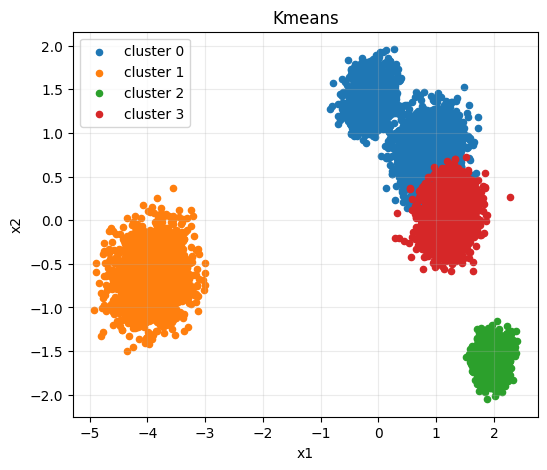

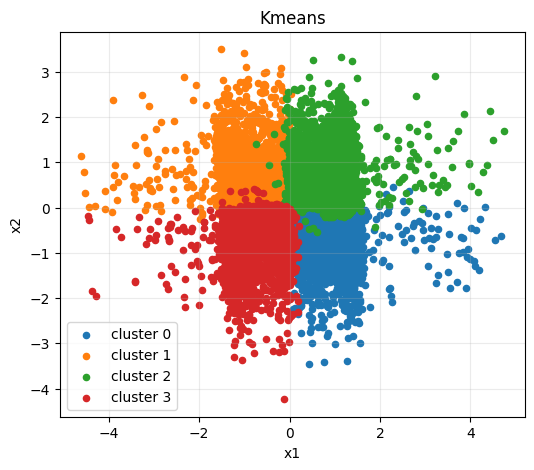

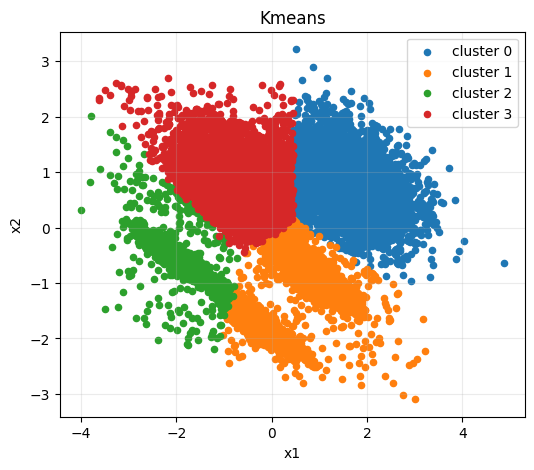

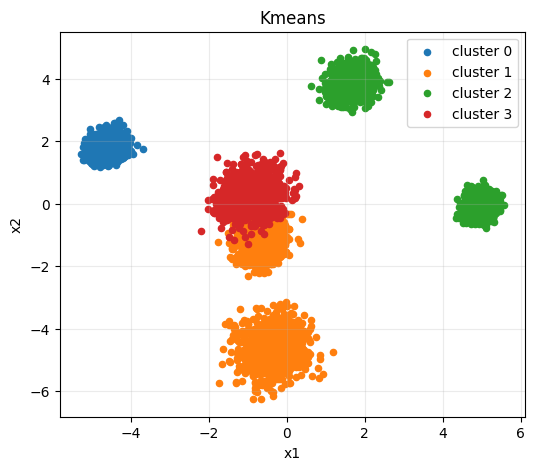

In [31]:
results = {}
k = 4
c=0
for i in x_scaled:
    model = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = model.fit_predict(i)
    print(labels)
    print(model.cluster_centers_)
    plot_clusters(i,labels,"Kmeans",save_file=image_folder+"Kmeans_"+datasets_files[c].replace(data_folder,'')+".png")
    save_with_clusters(labels,datasets[c],save_path=artifacts_folder+"labels/"+"Kmeans_"+datasets_files[c].replace(data_folder,''))
    del model
    results["Kmeans-"+datasets_files[c].replace(data_folder,'')]= [safe_internal_metrics(i, labels),summarize_labels(labels)]
    c+=1


(12000,)


C:\Users\study\AppData\Local\Temp\ipykernel_19896\4099117291.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(8000,)


C:\Users\study\AppData\Local\Temp\ipykernel_19896\4099117291.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(15000,)


C:\Users\study\AppData\Local\Temp\ipykernel_19896\4099117291.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(5490,)


C:\Users\study\AppData\Local\Temp\ipykernel_19896\4099117291.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


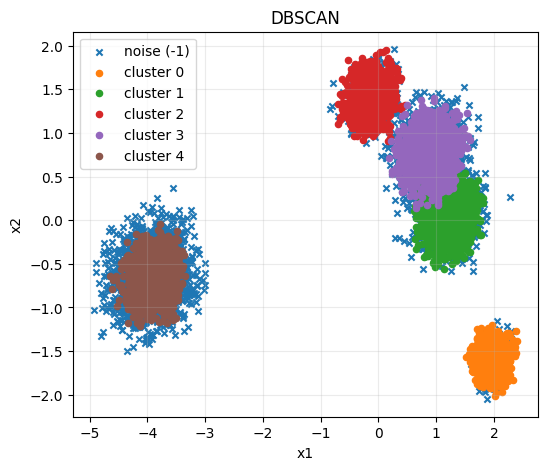

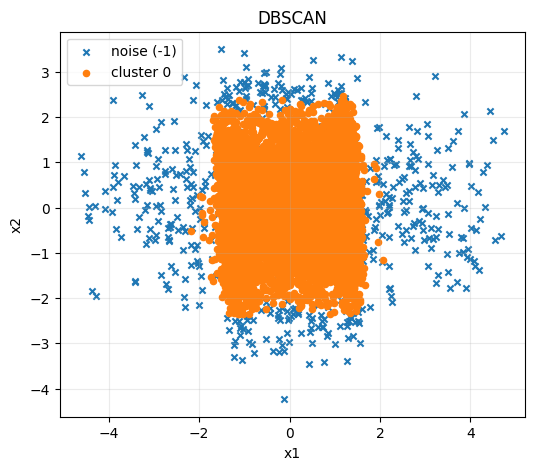

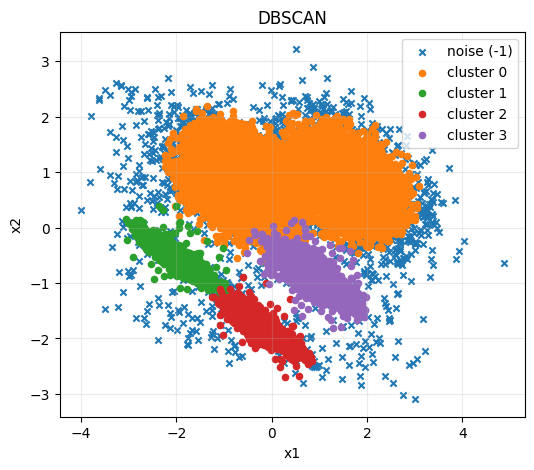

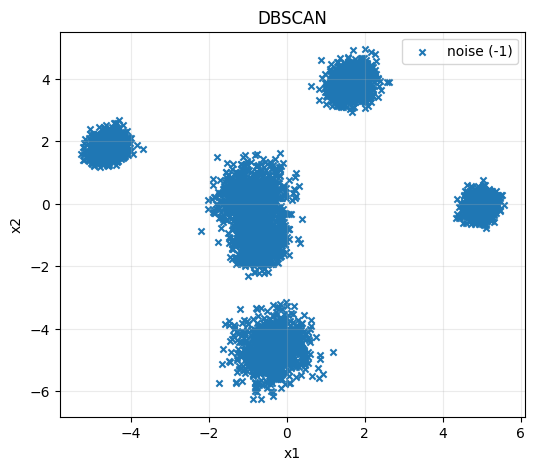

In [32]:
c=0
for i in x_scaled:

    db = DBSCAN(eps=0.5, min_samples=50)
    labels = db.fit_predict(i)
    print(labels.shape)
    plot_clusters(i,labels,"DBSCAN",save_file=image_folder+"DBSCAN_"+datasets_files[c].replace(data_folder,'')+".png")
    del db
    
    #stats = summarize_labels(labels)
  
    save_with_clusters(labels,datasets[c],save_path=artifacts_folder+"labels/"+"DBSCAN_"+datasets_files[c].replace(data_folder,''))
    results["DBSCAN-"+datasets_files[c].replace(data_folder,'')] = [safe_internal_metrics(i, labels),summarize_labels(labels)]
    c+=1


In [33]:
results

{'Kmeans-S07-hw-dataset-01.csv': [{'silhouette': 0.38330054183984447,
   'calinski_harabasz': 9427.499744196684,
   'davies_bouldin': 1.1603490405338497},
  {'n_points': 12000, 'n_clusters': 4, 'n_noise': 0.0, 'noise_share': 0.0}],
 'Kmeans-S07-hw-dataset-02.csv': [{'silhouette': 0.2515088157020451,
   'calinski_harabasz': 2915.5976490257517,
   'davies_bouldin': 1.2994936008185958},
  {'n_points': 8000, 'n_clusters': 4, 'n_noise': 0.0, 'noise_share': 0.0}],
 'Kmeans-S07-hw-dataset-03.csv': [{'silhouette': 0.3146186578997614,
   'calinski_harabasz': 6492.278930703823,
   'davies_bouldin': 1.1596756007747975},
  {'n_points': 15000, 'n_clusters': 4, 'n_noise': 0.0, 'noise_share': 0.0}],
 'Kmeans-S07-hw-dataset-04.csv': [{'silhouette': 0.3932331126912458,
   'calinski_harabasz': 2324.370923902055,
   'davies_bouldin': 1.1154367749029954},
  {'n_points': 5490, 'n_clusters': 4, 'n_noise': 0.0, 'noise_share': 0.0}],
 'DBSCAN-S07-hw-dataset-01.csv': [{'silhouette': 0.43184552373943935,
   'ca

In [34]:
save_json({"results": results}, Path(artifacts_folder)/"metrics_summary.json")